<a href="https://colab.research.google.com/github/yihong1011/TibameML/blob/main/08_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
path = "/content/drive/MyDrive/AI 資料工程師班01期/DeepLearning/train.zip"

In [61]:
import zipfile
f = zipfile.ZipFile(path)
f.extractall()

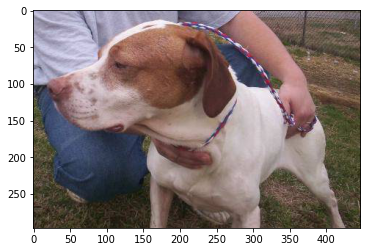

In [62]:
import glob
import matplotlib.pyplot as plt
from PIL import Image
fs = glob.glob("train/*")
plt.imshow(Image.open(fs[5]))

In [63]:
import random
import pandas as pd
dogs = glob.glob("train/dog.*")
random.shuffle(dogs)
cats = glob.glob("train/cat.*")
random.shuffle(cats)

train_df = pd.DataFrame({
    "path":dogs[:900] + cats[:900],
    "target":[0]*900 + [1]*900
})

validate_df = pd.DataFrame({
    "path":dogs[900:950] + cats[900:950],
    "target":[0]*50 + [1]*50
})

test_df = pd.DataFrame({
    "path":dogs[950:1000] + cats[950:1000],
    "target":[0]*50 + [1]*50
})

In [64]:
import tensorflow as tf
vgg = tf.keras.applications.VGG16(
    include_top=False, # 不需要原MLP
    input_shape=(224,224,3), # 輸入尺寸
)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

for l in vgg.layers:
  l.trainable = False

layers = [
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")          
]
layers = vgg.layers + layers
model = Sequential(layers)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import BatchNormalization

for l in vgg.layers:
  l.trainable = False

layers = [
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")          
]
layers = vgg.layers + layers
model = Sequential(layers)
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [67]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
       optimizer="adam",
       metrics=["accuracy"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


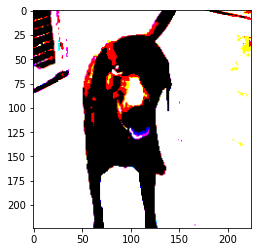

In [68]:
import numpy as np
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
fs = glob.glob("train/*")
target = fs[20]

# 預處理(要照你偷來的模型做)
from tensorflow.keras.applications.vgg16 import preprocess_input
img = Image.open(target).resize((224, 224)).convert("RGB")
img_np = preprocess_input(np.array(img))
plt.imshow(img_np)

In [69]:
x_train = np.array(train_df["path"])
y_train = np.array(train_df["target"])
x_validate = np.array(validate_df["path"])
y_validate = np.array(validate_df["target"])
x_test = np.array(test_df["path"])
y_test = np.array(test_df["target"])

In [70]:
from tensorflow.keras.applications.vgg16 import preprocess_input

def get_data(x, y, batch=None):
  # 如果不是None, 那代表是數字(20), 隨機20個idx
  # 如果是None, 那就沒有隨機, 拿全部
  if batch is not None:
    idx = np.random.randint(0, len(x), size=batch)
    x, y = x[idx], y[idx]
  # img_pre: preprocess過後的圖片
  # img_ori: 沒有preprocess的圖片
  img_pre, img_ori = [], []
  # 走過我的每一個path
  for p in x:
    # 讀取圖片並且預處理
    img = Image.open(p).convert("RGB").resize((224, 224))
    img = np.array(img)
    img_pre.append(preprocess_input(img))
    img_ori.append(img)
  # 回傳(預處理過後圖片, 沒處理圖片, 答案)
  return (np.array(img_pre), np.array(img_ori), y)
# 使用範例
x, x_ori, y = get_data(x_train, y_train, 10)
print(x.shape)
print(x_ori.shape)
print(y.shape)
# print(x)

(10, 224, 224, 3)
(10, 224, 224, 3)
(10,)


In [71]:
# validate和test全部讀出來
xv, xv_ori, yv = get_data(x_validate, y_validate)
xt, xt_ori, yt = get_data(x_test, y_test)
print(xv.shape)
print(xt.shape)

(100, 224, 224, 3)
(100, 224, 224, 3)


In [72]:
# 我沒有使用fit: 因為使用fit你一定要把全部圖都讀好(現實世界不太可能)
# 真的自己一步一步來: train_on_batch, test_on_batch
for i in range(50):
    x, _, y = get_data(x_train, y_train, batch=20)
    result = model.train_on_batch(x, y)
    print("train:", result)
    result = model.test_on_batch(xv, yv)
    print("validate:", result)
    print("-" * 15, i, "end", "-" * 15)

train: [0.7427986860275269, 0.44999998807907104]
validate: [1.741424560546875, 0.5899999737739563]
--------------- 0 end ---------------
train: [0.6458376049995422, 0.6499999761581421]
validate: [1.1649404764175415, 0.5799999833106995]
--------------- 1 end ---------------
train: [0.7407227754592896, 0.550000011920929]
validate: [1.035496711730957, 0.6000000238418579]
--------------- 2 end ---------------
train: [0.686670184135437, 0.699999988079071]
validate: [0.8874496221542358, 0.6200000047683716]
--------------- 3 end ---------------
train: [0.6825183033943176, 0.6000000238418579]
validate: [0.7748712301254272, 0.6499999761581421]
--------------- 4 end ---------------
train: [0.6428831815719604, 0.6000000238418579]
validate: [0.7038029432296753, 0.6600000262260437]
--------------- 5 end ---------------
train: [0.5645762085914612, 0.75]
validate: [0.6400765776634216, 0.6899999976158142]
--------------- 6 end ---------------
train: [0.6310166716575623, 0.699999988079071]
validate: [0

In [73]:
pre = model.predict(xt).argmax(axis=1)
model.evaluate(xt, yt)

4/4 [==============================] - 1s 99ms/step - loss: 0.2584 - accuracy: 0.9200


[0.25841227173805237, 0.9200000166893005]

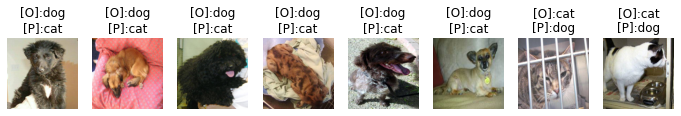

In [74]:
import numpy as np
# 找出True(預測錯誤)的位置
idx = np.nonzero(pre != yt)[0]
idx = idx[:200]
pre_false_label = yt[idx]
pre_false_pre = pre[idx]
pre_false_img = xt_ori[idx]
# !
trans = ["dog", "cat"]
plt.figure(figsize=(15, 5))
width = 10
height = len(idx) // width + 1
for i in range(len(idx)):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(trans[pre_false_label[i]], trans[pre_false_pre[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(pre_false_img[i])

url:https://wowlavie-aws.hmgcdn.com/file/article_all/popcat%E6%88%AA%E5%9C%96jpg.jpg
dog 的機率: 0.333
cat 的機率: 0.667


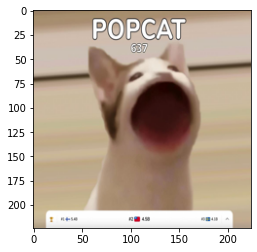

In [80]:
import requests
# pillow
from PIL import Image
url = input("url:")
response = requests.get(url, stream=True)
img = Image.open(response.raw).convert("RGB").resize((224, 224))
img_np = np.array(img).reshape(1, 224, 224, 3)
# (32, 32, 3) -> (1, 32, 32, 3)
img_np_pre = preprocess_input(img_np)
proba = model.predict(img_np_pre)[0]
for p, n in zip(proba, trans):
    print(n, "的機率:", round(p, 3))
plt.imshow(img)